C2 Fit from t =  2  to  8 

C3 Fit from t =  3  to  7 

Points included for fit:  13
{N2pt, N3pt}={3,2} state fit: 7 parameters

DOF =  4
Flow tau =  0.0
chi2dof 0.3857(3413) 

Akaike Information Criterion (AIC) = 22.62815758097925
Corrected AIC (AICc) = 82.62815758097925 

  M0 = 0.4740(0094) = 0.47395959940 ± 0.00941168203
  A0^2 = 5.97(41)e-10 = 0.00000000060 ± 0.00000000004
  M1 = 1.2923(1830) = 1.29233312663 ± 0.18301933106
  A1^2 = 8.81(211)e-10 = 0.00000000088 ± 0.00000000021
 O00 = 1.3739(0504) = 1.37391567097 ± 0.05035899779
 O01 = -0.1658(1608) = -0.16576656881 ± 0.16079615092
 O11 = 0.5003(0006) = 0.50025708723 ± 0.00057698032
  M2 = 1.5007(0027) = 1.50067009736 ± 0.00271241036
  A2 = 1.02(2)e-5 = 0.00001018850 ± 0.00000019621
A1^2 / A0^2 = 0.6775(1354) = 0.677491 ± 0.135423

 0.4740(0094) & 1.2923(1830) & 5.97(41)e-10 & 8.81(211)e-10 & 0.6775(1354) & 0.3857(3413) & 22.62815758097925 & 82.62815758097925

 & 1.3739(0504) & -0.1658(1608) & 0.5003(0006)




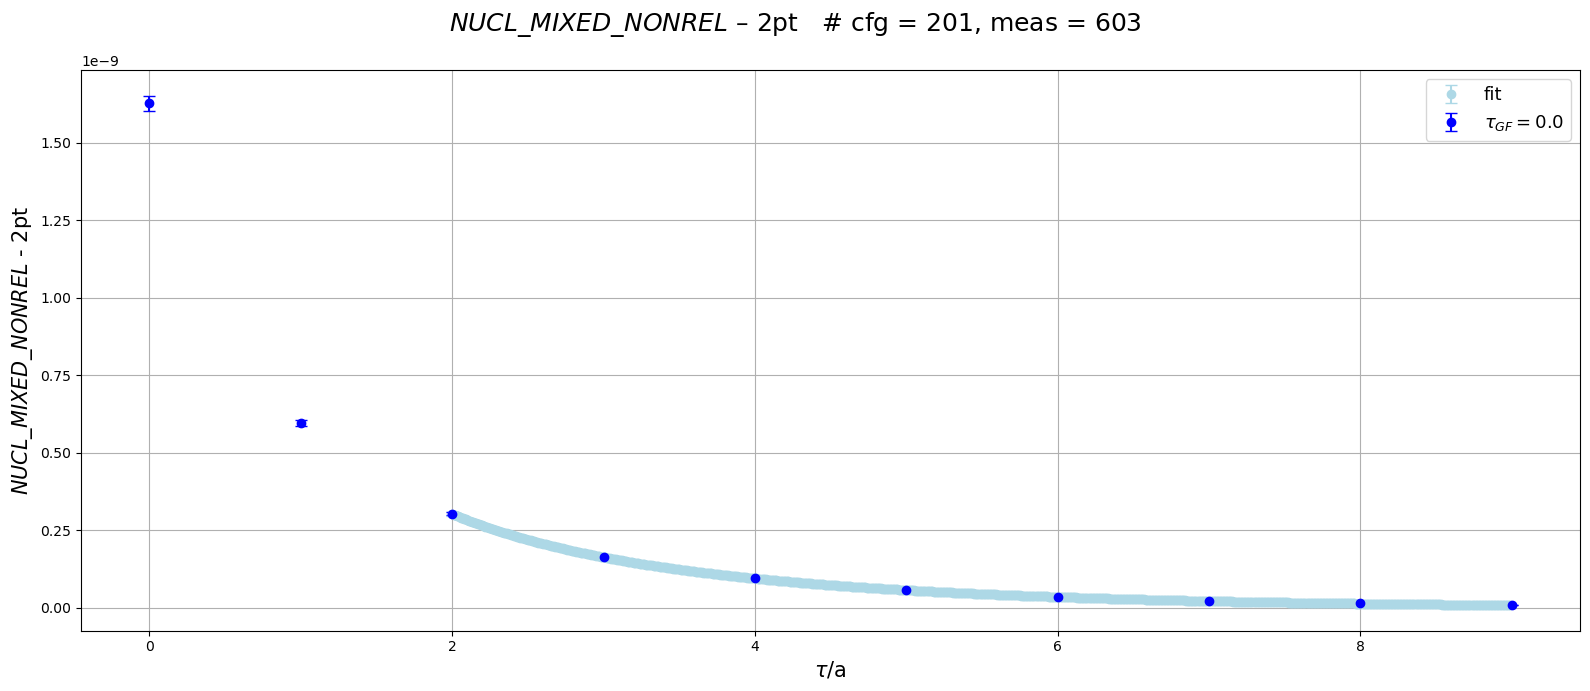

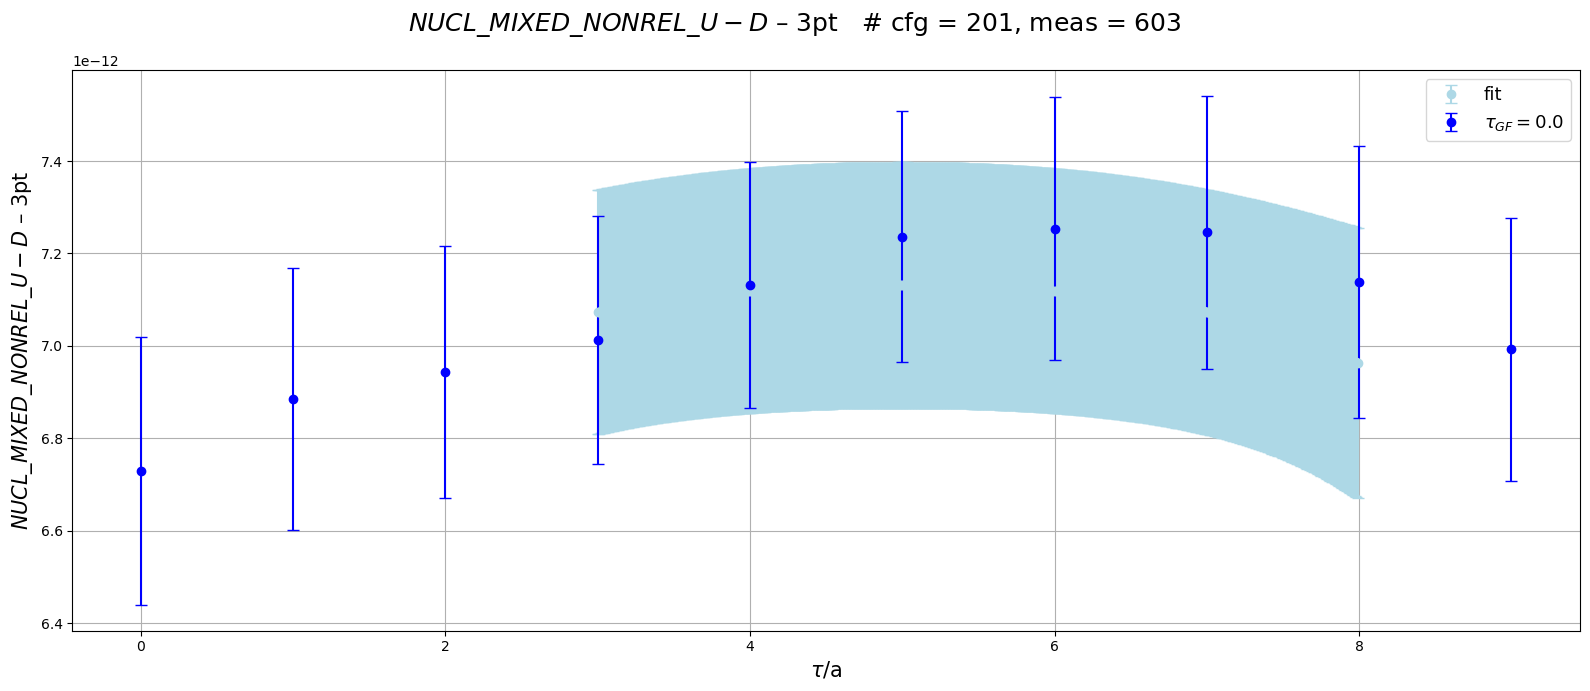

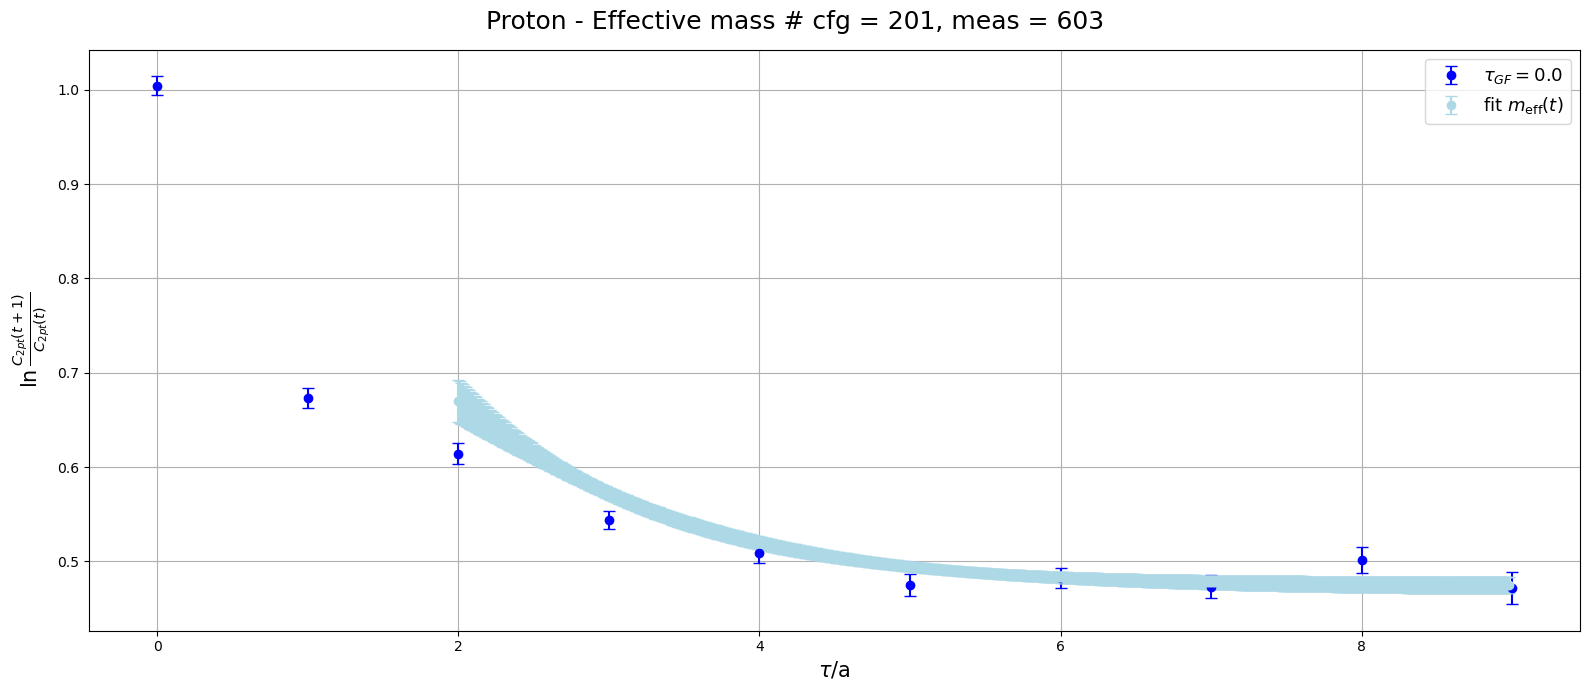

In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import gvar as gv
import lsqfit

cfglist = (
    pd.read_csv("/pscratch/sd/h/hari_8/production_nEDM_LANL/config_numbers.txt", header=None, dtype=str)  # 1-column DataFrame
      .squeeze("columns")                                      # -> Series
      .tolist()                                                # -> Python list
)


def fmt_err(mean, err):
    # switch to scientific if very small/big
    if mean and (abs(mean) < 1e-3 or abs(mean) >= 1e3):
        m_str = f"{mean:.2e}"           # e.g. "2.86e-08"
        mant, exp = m_str.split("e")
        ndec = len(mant.split(".")[1])  # digits in mantissa
        err_int = int(round(err / 10**int(exp) * 10**ndec))
        return f"{mant}({err_int})e{int(exp)}"
    else:
        ndec = 4                        # choose 4 decimal places
        m_str = f"{mean:.{ndec}f}"      # e.g. "0.4721"
        err_int = int(round(err * 10**ndec))
        return f"{m_str}({err_int:0{ndec}d})"
        
def Jackknifeset(datalist): #this gives Jackknife set for given sent of values
    N = len(datalist)
    Jackknife_set = []
    for i in range(N): #Jackknife
        sliced_list = datalist[:(i)] + datalist[(i+1):]
        Jackknife_set.append(np.mean(sliced_list))
    return Jackknife_set
    
def Jackknife(datalist): #for given Jackknifeset
    N = len(datalist)
    theta_bar = np.mean(datalist)
    theta_nminus_theta_bar = []
    for i in range(len(datalist)): #Jackknife
        theta_n = datalist[(i)]
        theta_nminus_theta_bar.append(np.square(theta_n-theta_bar))
    sigma_sq = ((N-1)/N)*np.sum(theta_nminus_theta_bar)
    return(theta_bar, np.sqrt(sigma_sq))

def C2_two_state(tau, M0, A0, M1, A1, M2, A2):
    return A0**2*np.exp(-M0*tau) + A1**2*np.exp(-M1*tau) + A2**2*np.exp(-M2*tau)

def C3_two_state(tau, M0, A0, M1, A1, O00, O01, O11):
    g00 = A0*A0*O00 * np.exp(-M0*snk_time)
    g01 = A0*A1*O01 * ( np.exp(-M0*(snk_time-tau))*np.exp(-M1*tau)
                      + np.exp(-M1*(snk_time-tau))*np.exp(-M0*tau) )
    g11 = A1*A1*O11 * np.exp(-M1*snk_time)
    return g00 + g01 + g11



    
snk_time = 10

def fcn(x, p):
    # x is a dict: x['c2'], x['c3']
    t   = x['c2']
    tau = x['c3']
    M0, A0, M1, A1, O00, O01, O11, M2, A2 = (
        p['M0'], p['A0'], p['M1'], p['A1'],
        p['O00'], p['O01'], p['O11'], p['M2'], p['A2']
    )
    C2 = A0**2 * np.exp(-M0*t) + A1**2 * np.exp(-M1*t)+ A2**2 * np.exp(-M2*t)

    g00 = A0*A0*O00 * np.exp(-M0*snk_time)
    g01 = A0*A1*O01 * (
        np.exp(-M0*(snk_time-tau))*np.exp(-M1*tau)
      + np.exp(-M1*(snk_time-tau))*np.exp(-M0*tau)
    )
    g11 = A1*A1*O11 * np.exp(-M1*snk_time)
    C3 = g00 + g01 + g11

    return {'c2':C2, 'c3':C3}

# very loose priors
paramas = 9
prior = {
   'M0' : gv.gvar(0.4721, 1.0),
   'A0' : gv.gvar(2.87870633e-05, 1.0),
   'M1' : gv.gvar(0.851, 1.0),
   'A1' : gv.gvar(2.82216990e-05, 1.0),
   'O00': gv.gvar(1.349, 1.0),
   'O01': gv.gvar(-0.130, 1.0),
   'O11': gv.gvar(0.5, 5.0),
   'M2' : gv.gvar(1.5, 0.2),
   'A2' : gv.gvar(1e-5, 1e-5)
}


def plot_all_flows(Gn, Num, cfglist, fit_ti_c2, fit_tf_c2, fit_ti_c3, fit_tf_c3):
    print("C2 Fit from t = ", fit_ti_c2 ," to ", fit_tf_c2-1,"\n")
    print("C3 Fit from t = ", fit_ti_c3 ," to ", fit_tf_c3-1,"\n")
    dofpluspara = (fit_tf_c2-fit_ti_c2)+(fit_tf_c3-fit_ti_c3)+1
    print("Points included for fit: ", dofpluspara )
    print("{N2pt, N3pt}={3,2} state fit: 7 parameters\n")
    dof = dofpluspara-paramas
    print("DOF = ", dof)
    flow_times = ["0p0"]#,"8p0", "12p5", "18p0"]
    tau_GF = [0]#, 8.0, 12.5, 18]
    colors = ['blue', 'green', 'red', 'purple']
    colorsfit = ['lightblue', 'lightgreen', 'lightcoral', 'plum']
    markers = ['o', 's', '^', 'D']

    fig1, ax1 = plt.subplots(figsize=(16,7))
    fig2, ax2 = plt.subplots(figsize=(16,7))
    fig3, ax3 = plt.subplots(figsize=(16,7))

    for i, WFt in enumerate(flow_times):
        print("Flow tau = ", np.sqrt(8*tau_GF[i]))
        # Load 3pt data
        U_pt3_cfg = []
        D_pt3_cfg = []
        pt2_cfg = []
        nocfg = 0
        for j, cfg in enumerate(cfglist):
            nocfg = nocfg+1
        
            U_file_path = f"/pscratch/sd/h/hari_8/production_nEDM_LANL/output_3pt2pt_flow/WF{WFt}_NUCL_U_MIXED_NONREL3pt_t{snk_time}_{cfg}.h5"
        
            with h5py.File(U_file_path, "r") as h5_file: 
                U_path_to_observable_cfgb = f"//NUCL_l0_g{Gn}_qz+0_qy+0_qx+0/001"
                U_observable_cfgb = h5_file[U_path_to_observable_cfgb]
                U_values = U_observable_cfgb[Num][()]

            #t0x0y0z0_t21x10y10z10_t42x20y20z20
            U_pt3_data = np.array(U_values)
            U_pt3_data1 = U_pt3_data[0:(0+(snk_time+1))]
            U_pt3_data2 = U_pt3_data[21:(21+(snk_time+1))]
            U_pt3_data3 = U_pt3_data[42:(42+(snk_time+1))]
            U_pt3_cfg.append((U_pt3_data1+U_pt3_data2+U_pt3_data3)/3)
        
            D_file_path = f"/pscratch/sd/h/hari_8/production_nEDM_LANL/output_3pt2pt_flow/WF{WFt}_NUCL_D_MIXED_NONREL3pt_t{snk_time}_{cfg}.h5"
        
            with h5py.File(D_file_path, "r") as h5_file: 
                D_path_to_observable_cfgb = f"//NUCL_l0_g{Gn}_qz+0_qy+0_qx+0/001"
                D_observable_cfgb = h5_file[D_path_to_observable_cfgb]
                D_values = D_observable_cfgb[Num][()]
        
            D_pt3_data = np.array(D_values)
            D_pt3_data1 = D_pt3_data[0:(0+(snk_time+1))]
            D_pt3_data2 = D_pt3_data[21:(21+(snk_time+1))]
            D_pt3_data3 = D_pt3_data[42:(42+(snk_time+1))]
            D_pt3_cfg.append((D_pt3_data1+D_pt3_data2+D_pt3_data3)/3)
    
        

            # Load 2pt data
            
            pt2_file_path = "/pscratch/sd/h/hari_8/production_nEDM_LANL/output_3pt2pt_flow/hadspec.h5"
        
            with h5py.File(pt2_file_path, "r") as h5_file: 
                pt2_path_to_observable_cfgb = f"//proton.D-2389.DG7_6.DG7_6.SS/{WFt}_had_{cfg}"
                pt2_observable_cfgb = h5_file[pt2_path_to_observable_cfgb]
                pt2_values = pt2_observable_cfgb["re"][()]
            pt2_data = np.array(pt2_values)
            pt2_data1 = pt2_data[0:(0+(snk_time+1))]
            pt2_data2 = pt2_data[21:(21+(snk_time+1))]
            pt2_data3 = pt2_data[42:(42+(snk_time+1))]
            pt2_cfg.append((pt2_data1+pt2_data2+pt2_data3)/3)

        # Compute jackknife
        
        
        pt3_JK_value = []
        pt3_JK_err = []
        pt2_JK_value = []
        pt2_JK_err = []
        pt3_jackk_set = []
        pt2_jackk_set = []
        pt22ffmass_JK_value = []
        pt22ffmass_JK_err = []
        for tau in range(snk_time):
            U_tau_Jackknifeset = Jackknifeset([U_pt3_cfg[i][tau] for i in range(len(U_pt3_cfg))])
            D_tau_Jackknifeset = Jackknifeset([D_pt3_cfg[i][tau] for i in range(len(D_pt3_cfg))])
            pt2_tau_Jackknifeset = Jackknifeset([pt2_cfg[i][tau] for i in range(len(pt2_cfg))])
            pt2_tau_1_Jackknifeset = Jackknifeset([pt2_cfg[i][tau+1] for i in range(len(pt2_cfg))])
            pt2ffmass_tau_Jackknifeset = np.log(pt2_tau_Jackknifeset)-np.log(pt2_tau_1_Jackknifeset)
            pt22ffmass_JK_value.append(Jackknife(np.array(pt2ffmass_tau_Jackknifeset))[0])
            pt22ffmass_JK_err.append(Jackknife(np.array(pt2ffmass_tau_Jackknifeset))[1])
            
            UD = (np.array(U_tau_Jackknifeset) - np.array(D_tau_Jackknifeset))
            pt3_JK_value_err = Jackknife(UD)

            pt2_JK_value_err = Jackknife(np.array(pt2_tau_Jackknifeset))

            pt3_jackk_set.append(UD)
            pt2_jackk_set.append(pt2_tau_Jackknifeset)

            pt3_JK_value.append(pt3_JK_value_err[0])
            pt3_JK_err.append(pt3_JK_value_err[1])

            pt2_JK_value.append(pt2_JK_value_err[0])
            pt2_JK_err.append(pt2_JK_value_err[1])
            
        
        n2 = fit_tf_c2 - fit_ti_c2
        n3 = fit_tf_c3 - fit_ti_c3
    
        data_samples = np.zeros((nocfg, n2+n3))
        for jk in range(nocfg):
            data_samples[jk, :n2]   = [pt2_jackk_set[t][jk]
                                       for t in range(fit_ti_c2, fit_tf_c2)]
            data_samples[jk, n2:]   = [pt3_jackk_set[t][jk]
                                       for t in range(fit_ti_c3, fit_tf_c3)]
    
        # jackknife covariance:
        mean_vec = data_samples.mean(axis=0)
        dev = data_samples - mean_vec
        cov = (nocfg-1)/nocfg * (dev.T @ dev)
        x_dict = {'c2': np.arange(fit_ti_c2, fit_tf_c2),'c3': np.arange(fit_ti_c3, fit_tf_c3)}
        param_names = ['M0','A0','M1','A1','O00','O01','O11','M2','A2']
        fits_jk = np.zeros((nocfg, len(param_names)))

        chi2perdofjk = []
        chi2jk = []
        plotfit_c2 = []
        plotfit_c3 = []
        t_fine_c2 = np.arange(fit_ti_c2, fit_tf_c2, 0.01)
        plotfit_effm = []
        for jk in range(nocfg):
            # build a gvar y-vector for this jackknife sample
            y_jk = gv.gvar(data_samples[jk], cov)
            y_dict_jk = {
              'c2': y_jk[:n2],
              'c3': y_jk[n2:]
            }
    
            # do the simultaneous correlated fit for this sample
            fit_jk = lsqfit.nonlinear_fit(
              data=(x_dict, y_dict_jk),
              prior=prior,
              fcn=fcn,
              debug=False
            )
            plotfit_c2.append(np.array([C2_two_state(t, fit_jk.p['M0'].mean, fit_jk.p['A0'].mean, fit_jk.p['M1'].mean, fit_jk.p['A1'].mean, fit_jk.p['M2'].mean, fit_jk.p['A2'].mean) for t in np.arange(fit_ti_c2, fit_tf_c2, 0.01)]))
            plotfit_c3.append(np.array([C3_two_state(t, fit_jk.p['M0'].mean, fit_jk.p['A0'].mean, fit_jk.p['M1'].mean, fit_jk.p['A1'].mean, fit_jk.p['O00'].mean, fit_jk.p['O01'].mean, fit_jk.p['O11'].mean) for t in np.arange(fit_ti_c3, fit_tf_c3, 0.01)]))
            C2_jk = plotfit_c2[-1]
            dt = t_fine_c2[1] - t_fine_c2[0]  # = 0.01
            effm_jk = np.log(C2_jk[:-1] / C2_jk[1:]) / dt
            plotfit_effm.append(effm_jk)


            # collect the *mean* values of each parameter
            fits_jk[jk] = [fit_jk.p[name].mean for name in param_names]
            chi2perdofjk.append(fit_jk.chi2 / fit_jk.dof)
            chi2jk.append(fit_jk.chi2)

        chi2dof = fmt_err(Jackknife(chi2perdofjk)[0],Jackknife(chi2perdofjk)[1])
        print("chi2dof", chi2dof,"\n")
        aic = 2 * paramas + Jackknife(chi2jk)[0]
        print("Akaike Information Criterion (AIC) =", aic)
        aicc = aic + (2 * paramas * (paramas + 1)) / (dofpluspara - paramas - 1)
        print("Corrected AIC (AICc) =", aicc,"\n")

        for idx, name in enumerate(param_names):
            values = fits_jk[:, idx]
            if name in {"A0", "A1"}:
                mean, err = Jackknife(np.square(values))
                print(f"{name:>4s}^2 = {fmt_err(mean, err)} = {mean:.11f} ± {err:.11f}")
            else:
                mean, err = Jackknife(values)
                print(f"{name:>4s} = {fmt_err(mean, err)} = {mean:.11f} ± {err:.11f}")
        A0sq_values = fits_jk[:, 1]
        A1sq_values = fits_jk[:, 3]
        mean_A1sqbyA0sq, err_A1sqbyA0sq = Jackknife(np.square(A0sq_values)/np.square(A1sq_values))
        print(f"A1^2 / A0^2 = {fmt_err(mean_A1sqbyA0sq, err_A1sqbyA0sq)} = {mean_A1sqbyA0sq:.6f} ± {err_A1sqbyA0sq:.6f}")
        def prlatx(pn, powr):
            return fmt_err(Jackknife(fits_jk[:, pn]**powr)[0], Jackknife(fits_jk[:, pn]**powr)[1])
        print(f"\n {prlatx(0, 1)} & {prlatx(2, 1)} & {prlatx(1, 2)} & {prlatx(3, 2)} & {fmt_err(mean_A1sqbyA0sq, err_A1sqbyA0sq)} & {chi2dof} & {aic} & {aicc}")
        print(f"\n & {prlatx(4, 1)} & {prlatx(5, 1)} & {prlatx(6, 1)}")

        
        pt2_fit_value = []
        pt3_fit_value = []
        pt2_fit_err = []
        pt3_fit_err = []
        time_fit_plt_c2 = np.arange(fit_ti_c2, fit_tf_c2, 0.01)
        time_fit_plt_c3 = np.arange(fit_ti_c3, fit_tf_c3, 0.01)
        for ttt in range(len(plotfit_c2[0])):
            plotfit_c2_me_err = Jackknife(np.array([plotfit_c2[JK][ttt] for JK in range(nocfg)]))
            pt2_fit_value.append(plotfit_c2_me_err[0])
            pt2_fit_err.append(plotfit_c2_me_err[1])
        for ttt in range(len(plotfit_c3[0])):
            plotfit_c3_me_err = Jackknife(np.array([plotfit_c3[JK][ttt] for JK in range(nocfg)]))
            pt3_fit_value.append(plotfit_c3_me_err[0])
            pt3_fit_err.append(plotfit_c3_me_err[1])
        meff_fit_mean = []
        meff_fit_err  = []
        for tttt in range(len(t_fine_c2)-1):
            arr = np.array([ plotfit_effm[jk][tttt] for jk in range(nocfg) ])
            m, e = Jackknife(arr)
            meff_fit_mean.append(m)
            meff_fit_err.append(e)
        
        
        print("\n")
        time_plt = np.arange(len(pt2_JK_value))
        ax1.errorbar(time_fit_plt_c2, pt2_fit_value, yerr=pt2_fit_err, fmt=markers[i], markersize=6, capsize=4, color=colorsfit[i], label="fit")
        ax1.errorbar(time_plt, pt2_JK_value, yerr=pt2_JK_err, fmt=markers[i], markersize=6, capsize=4, color=colors[i], label=f"$\\tau_{{GF}} = {np.sqrt(8*tau_GF[i])}$")
        ax2.errorbar(time_fit_plt_c3, pt3_fit_value, yerr=pt3_fit_err, fmt=markers[i], markersize=6, capsize=4, color=colorsfit[i], label="fit")
        ax2.errorbar(time_plt, pt3_JK_value, yerr=pt3_JK_err, fmt=markers[i], markersize=6, capsize=4, color=colors[i], label=f"$\\tau_{{GF}} = {np.sqrt(8*tau_GF[i])}$")
        ax3.errorbar(time_plt, pt22ffmass_JK_value, yerr=pt22ffmass_JK_err, fmt=markers[i], markersize=6, capsize=4, color=colors[i], label=f"$\\tau_{{GF}} = {np.sqrt(8*tau_GF[i])}$")
        ax3.errorbar(t_fine_c2[:-1], meff_fit_mean, yerr=meff_fit_err, fmt=markers[i], markersize=6, capsize=4, color=colorsfit[i], label='fit $m_{\\rm eff}(t)$')

    ax1.set_xlabel("$\\tau$/a", fontsize=15)
    ax1.set_ylabel("${NUCL\\_MIXED\\_NONREL}$ - 2pt", fontsize=15)
    fig1.suptitle(f"${{NUCL\\_MIXED\\_NONREL}}$ – 2pt   # cfg = {nocfg}, meas = {nocfg*3}", fontsize=18)
    ax1.tick_params(labelsize=10)
    ax1.grid(True)
    ax1.legend(fontsize=13)
    fig1.tight_layout()
    #fig1.savefig(f"pt2_Nu_4meas_all_flows_t{snk_time}.pdf", dpi=500)
    fig1.show()  
    
    
    ax2.set_xlabel("$\\tau$/a", fontsize=15)
    ax2.set_ylabel(r"${NUCL\_MIXED\_NONREL\_U-D}$ – 3pt", fontsize=15)
    fig2.suptitle(f"${{NUCL\\_MIXED\\_NONREL\\_U-D}}$ – 3pt   # cfg = {nocfg}, meas = {nocfg*3}", fontsize=18)
    ax2.tick_params(labelsize=10)
    ax2.grid(True)
    ax2.legend(fontsize=13)
    fig2.tight_layout()
    #fig2.savefig(f"3pt_Nu_4meas_all_flows_t{snk_time}.pdf", dpi=500)
    fig2.show()

    ax3.set_xlabel("$\\tau$/a", fontsize=15)
    ax3.set_ylabel("$\\ln{\\frac{C_{2pt}(t+1)}{C_{2pt}(t)}}$", fontsize=15)
    fig3.suptitle(f"Proton - Effective mass # cfg = {nocfg}, meas = {nocfg*3}", fontsize=18)
    ax3.tick_params(labelsize=10)
    ax3.grid(True)
    ax3.legend(fontsize=13)
    fig3.tight_layout()
    #fig1.savefig(f"pt2_pion_4meas_all_flows_t{snk_time}.pdf", dpi=500)
    fig3.show() 

    


plot_all_flows(11, "im", cfglist, 2, 9, 3, 8)

C2 Fit from t =  2  to  8 

C3 Fit from t =  3  to  7 

Points included for fit:  13
{N2pt, N3pt}={3,2} state fit: 7 parameters

DOF =  4
Flow tau =  0.0
chi2dof 0.8359(5073) 

Akaike Information Criterion (AIC) = 28.030269285301017
Corrected AIC (AICc) = 88.03026928530102 

  M0 = 0.4721(0102) = 0.47210341539 ± 0.01023667440
  A0^2 = 5.85(44)e-10 = 0.00000000058 ± 0.00000000004
  M1 = 1.2611(1845) = 1.26108900798 ± 0.18447313405
  A1^2 = 8.42(192)e-10 = 0.00000000084 ± 0.00000000019
 O00 = 1.5156(1913) = 1.51561262726 ± 0.19127695180
 O01 = -0.3847(3709) = -0.38474483498 ± 0.37090044745
 O11 = 0.5023(0043) = 0.50226057804 ± 0.00428655772
  M2 = 1.5003(0026) = 1.50025115682 ± 0.00259028446
  A2 = 1.00(3)e-5 = 0.00000999705 ± 0.00000026619
A1^2 / A0^2 = 0.6943(1290) = 0.694264 ± 0.129003

 0.4721(0102) & 1.2611(1845) & 5.85(44)e-10 & 8.42(192)e-10 & 0.6943(1290) & 0.8359(5073) & 28.030269285301017 & 88.03026928530102

 & 1.5156(1913) & -0.3847(3709) & 0.5023(0043)




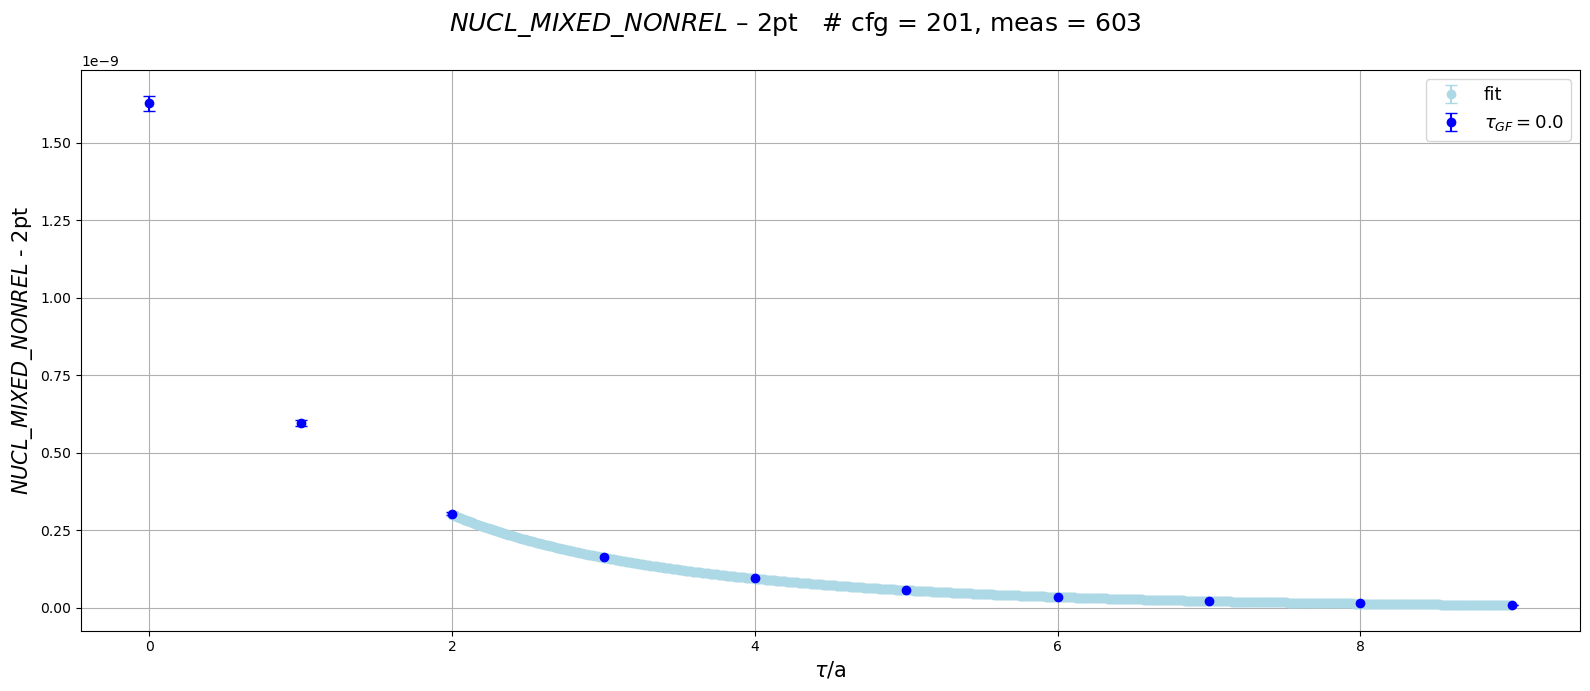

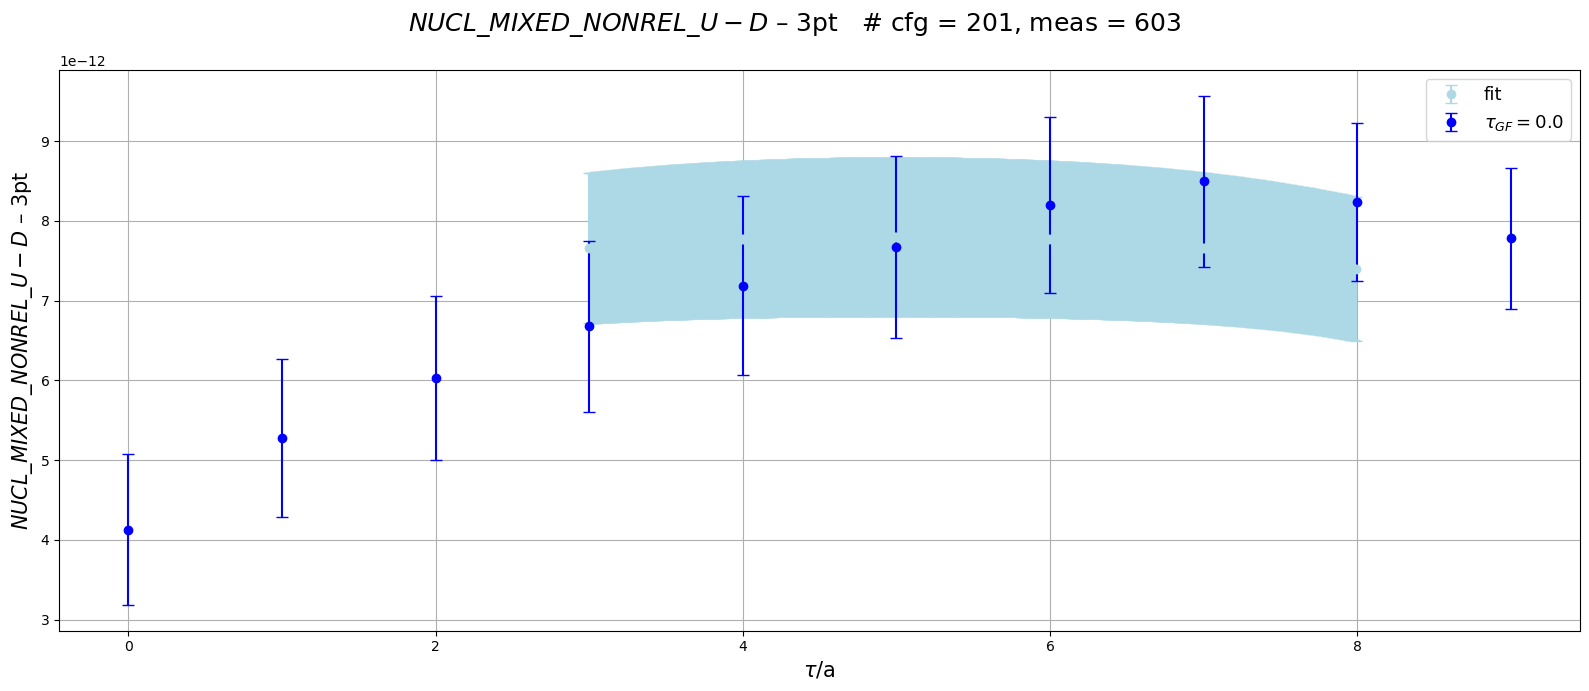

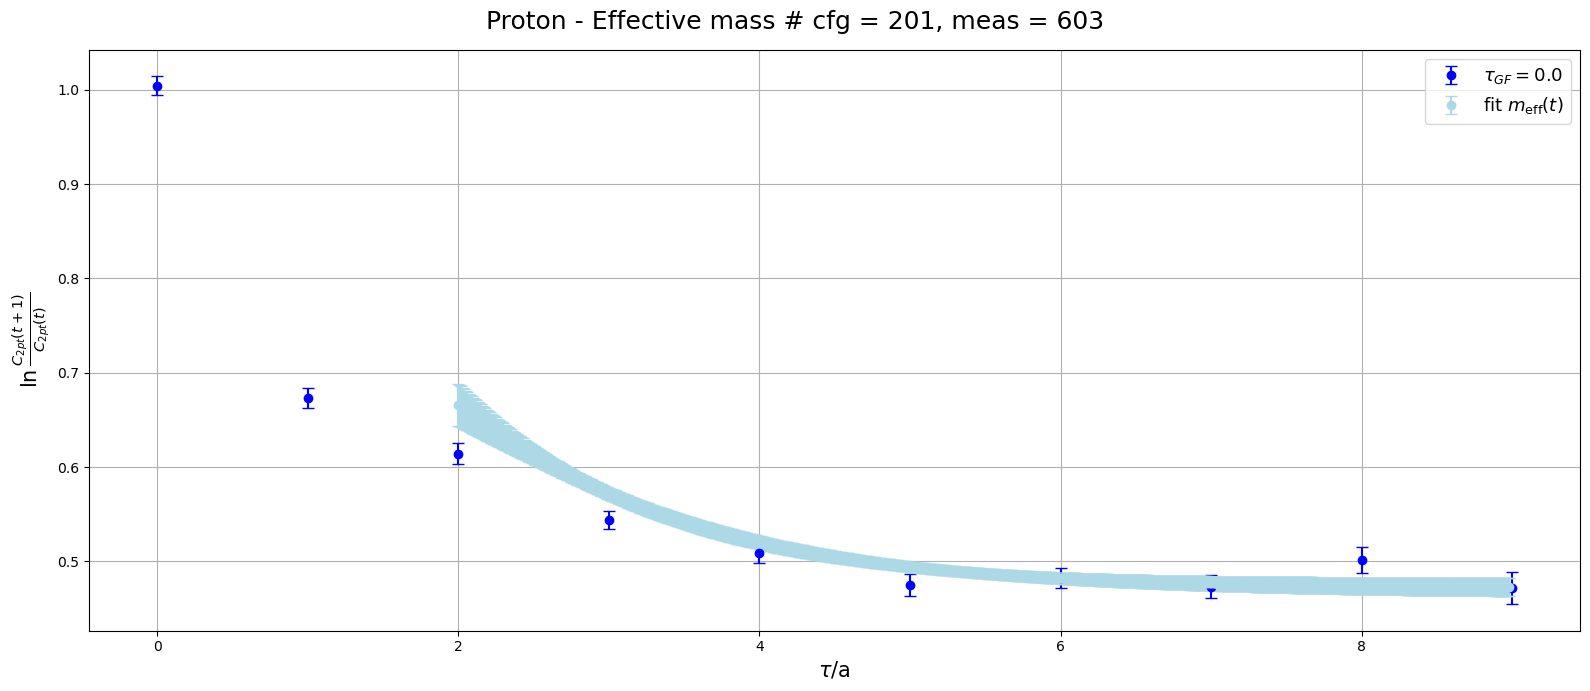

In [3]:
plot_all_flows(0, "re", cfglist, 2, 9, 3, 8)

C2 Fit from t =  2  to  8 

C3 Fit from t =  3  to  7 

Points included for fit:  13
{N2pt, N3pt}={3,2} state fit: 7 parameters

DOF =  4
Flow tau =  0.0
chi2dof 0.3377(3081) 

Akaike Information Criterion (AIC) = 22.051982896392623
Corrected AIC (AICc) = 82.05198289639262 

  M0 = 0.4707(0105) = 0.47071199605 ± 0.01045135523
  A0^2 = 5.86(45)e-10 = 0.00000000059 ± 0.00000000005
  M1 = 1.2486(1785) = 1.24864700752 ± 0.17851686470
  A1^2 = 8.52(183)e-10 = 0.00000000085 ± 0.00000000018
 O00 = 1.1370(0470) = 1.13697712825 ± 0.04702608988
 O01 = 0.1916(1091) = 0.19162941536 ± 0.10908788316
 O11 = 0.4968(0055) = 0.49675166963 ± 0.00549612433
  M2 = 1.4996(0022) = 1.49958242962 ± 0.00223328090
  A2 = 9.92(28)e-6 = 0.00000991670 ± 0.00000028198
A1^2 / A0^2 = 0.6874(1184) = 0.687425 ± 0.118377

 0.4707(0105) & 1.2486(1785) & 5.86(45)e-10 & 8.52(183)e-10 & 0.6874(1184) & 0.3377(3081) & 22.051982896392623 & 82.05198289639262

 & 1.1370(0470) & 0.1916(1091) & 0.4968(0055)




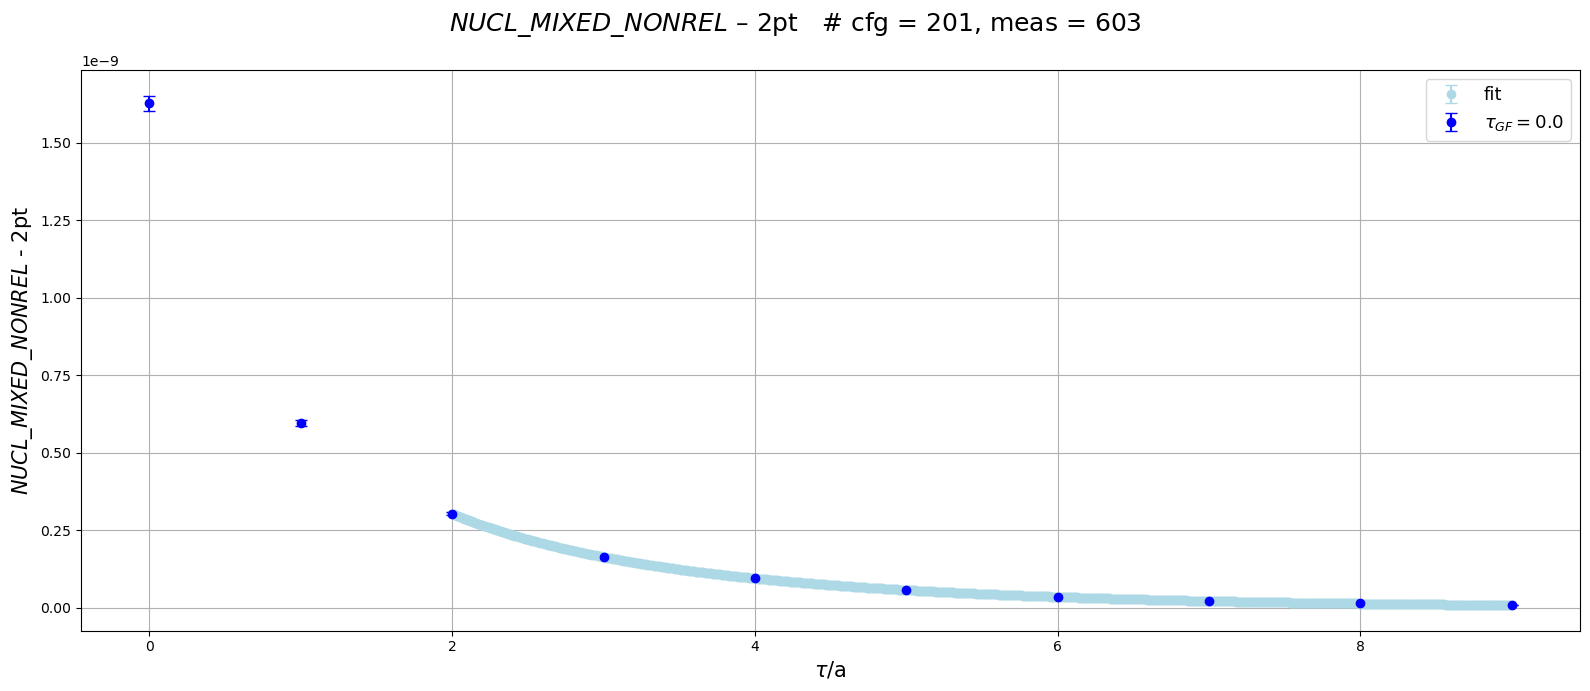

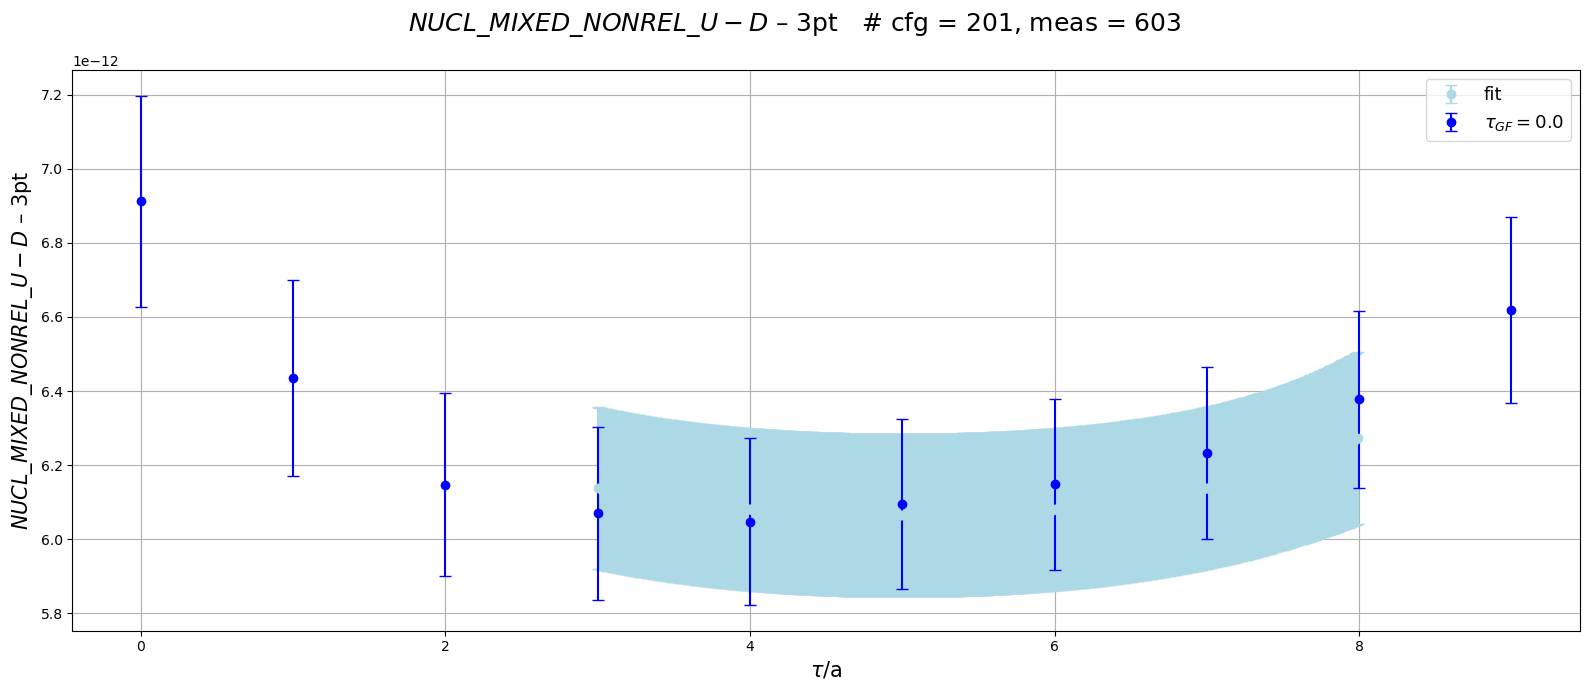

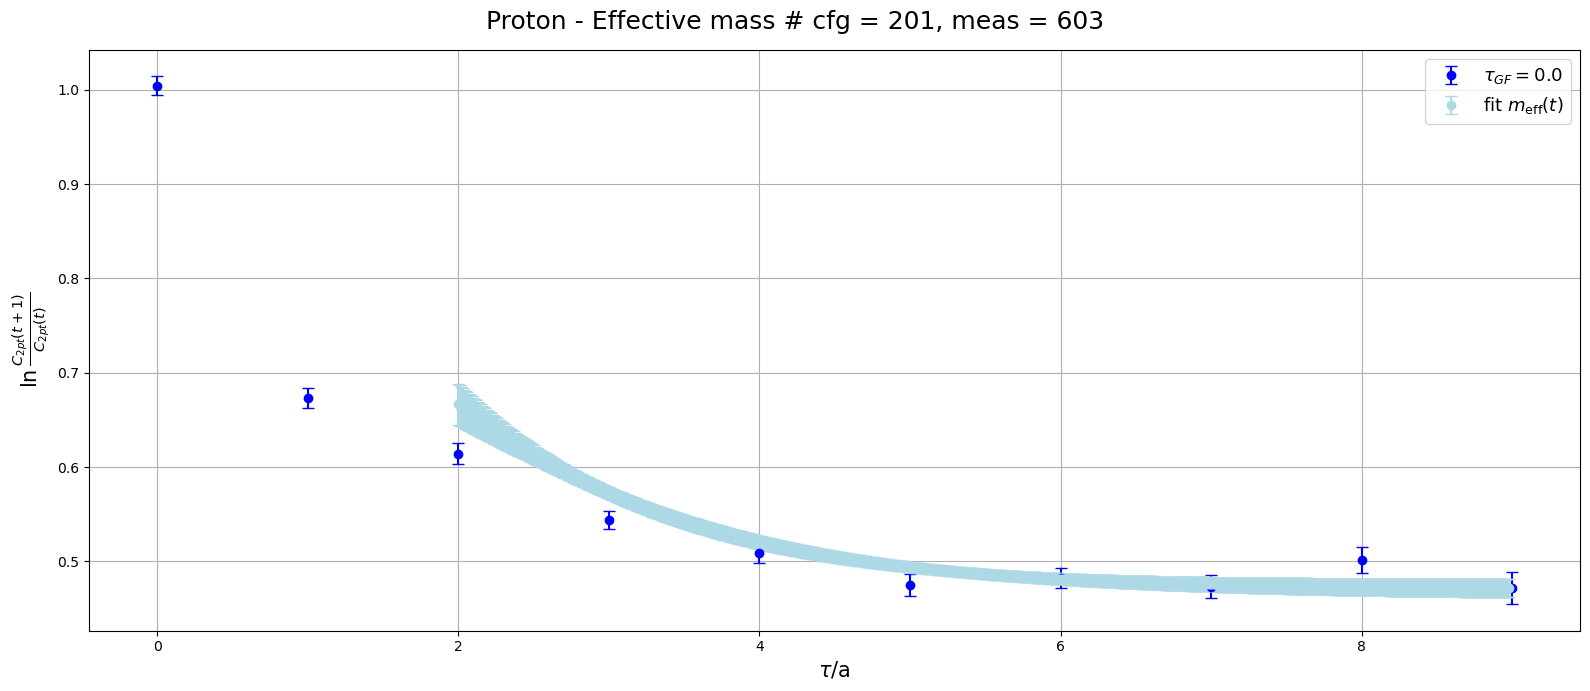

In [4]:
plot_all_flows(3, "im", cfglist, 2, 9, 3, 8)

C2 Fit from t =  2  to  9 

C3 Fit from t =  3  to  7 

Points included for fit:  13
{N2pt, N3pt}={3,2} state fit: 9 parameters

DOF =  4
Flow tau =  0.0
Akaike Information Criterion (AIC) = 18.902689472210618
Corrected AIC (AICc) = 78.90268947221062
Total Chi-Square = 0.9026894722106191
Chi-Square per DOF = 0.22567236805265478
Fit parameter:

  M0 = 0.4672(0888) = 0.46716312954 ± 0.08878099551
A0^2 = 5.75(364)e-10 = 0.00000000057 ± 0.00000000036
  M1 = 1.2290(8794) = 1.22897126403 ± 0.87936855195
A1^2 = 9.01(1633)e-10 = 0.00000000090 ± 0.00000000163
  M2 = 1.0049(11447) = 1.00486431661 ± 1.14468112522
A2^2 = 1.37(15710)e-11 = 0.00000000001 ± 0.00000000157
 O00 = 1.4402(5026) = 1.44024313809 ± 0.50260104329
 O01 = 0.1961(23642) = 0.19610122430 ± 2.36421843704
 O11 = 0.6641(150273) = 0.66406906963 ± 15.02725226538

 A1^2 / A0^2 = 56.7334(108290817) = 56.733385 ± 10829.081657




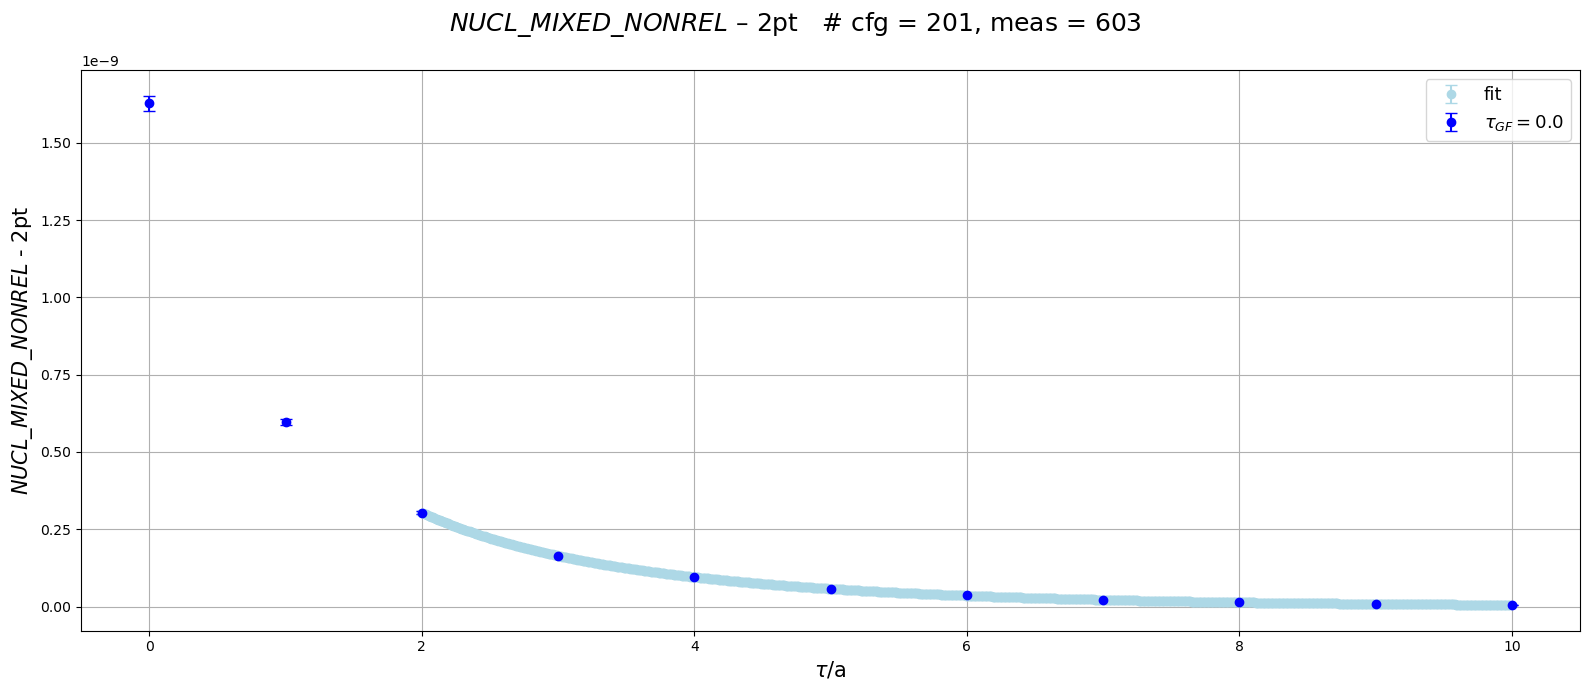

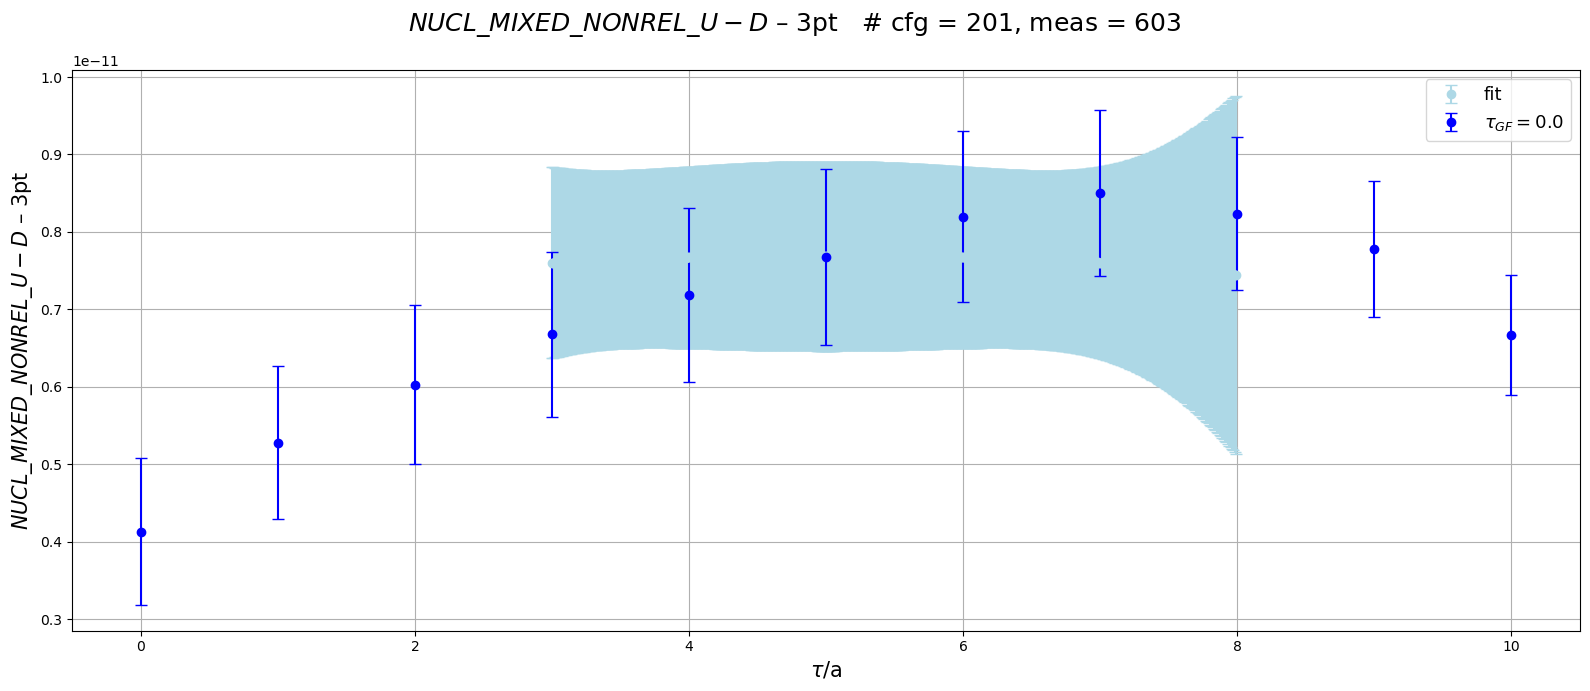

In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import pandas as pd  
from  scipy.optimize import least_squares
from scipy.optimize import curve_fit

cfglist = (
    pd.read_csv("/pscratch/sd/h/hari_8/production_nEDM_LANL/config_numbers.txt", header=None, dtype=str)  # 1-column DataFrame
      .squeeze("columns")                                      # -> Series
      .tolist()                                                # -> Python list
)


def fmt_err(mean, err):
    # switch to scientific if very small/big
    if mean and (abs(mean) < 1e-3 or abs(mean) >= 1e3):
        m_str = f"{mean:.2e}"           # e.g. "2.86e-08"
        mant, exp = m_str.split("e")
        ndec = len(mant.split(".")[1])  # digits in mantissa
        err_int = int(round(err / 10**int(exp) * 10**ndec))
        return f"{mant}({err_int})e{int(exp)}"
    else:
        ndec = 4                        # choose 4 decimal places
        m_str = f"{mean:.{ndec}f}"      # e.g. "0.4721"
        err_int = int(round(err * 10**ndec))
        return f"{m_str}({err_int:0{ndec}d})"
        
def Jackknifeset(datalist): #this gives Jackknife set for given sent of values
    N = len(datalist)
    Jackknife_set = []
    for i in range(N): #Jackknife
        sliced_list = datalist[:(i)] + datalist[(i+1):]
        Jackknife_set.append(np.mean(sliced_list))
    return Jackknife_set
    
def Jackknife(datalist): #for given Jackknifeset
    N = len(datalist)
    theta_bar = np.mean(datalist)
    theta_nminus_theta_bar = []
    for i in range(len(datalist)): #Jackknife
        theta_n = datalist[(i)]
        theta_nminus_theta_bar.append(np.square(theta_n-theta_bar))
    sigma_sq = ((N-1)/N)*np.sum(theta_nminus_theta_bar)
    return(theta_bar, np.sqrt(sigma_sq))

def C2_two_state(tau, M0, A0, M1, A1, M2, A2):
    return A0**2*np.exp(-M0*tau) + A1**2*np.exp(-M1*tau) + A2**2*np.exp(-M2*tau)

def C3_two_state(tau, M0, A0, M1, A1, O00, O01, O11):
    g00 = A0*A0*O00 * np.exp(-M0*snk_time)
    g01 = A0*A1*O01 * ( np.exp(-M0*(snk_time-tau))*np.exp(-M1*tau)
                      + np.exp(-M1*(snk_time-tau))*np.exp(-M0*tau) )
    g11 = A1*A1*O11 * np.exp(-M1*snk_time)
    return g00 + g01 + g11

def residuals(params, tau_c2, tau_c3, C2_data, C3_data):
    M0, A0, M1, A1, M2, A2, O00, O01, O11 = params
    # model predictions
    C2_pred = C2_two_state(tau_c2, M0, A0, M1, A1, M2, A2)
    C3_pred = C3_two_state(tau_c3, M0, A0, M1, A1, O00, O01, O11)
    # residuals for both datasets
    res2 = C2_pred - C2_data
    res3 = C3_pred - C3_data
    return np.concatenate([res2, res3])


    
snk_time = 10

#p0 = [05.34935666e-01, 2.87870633e-05, 1.97328241e+00, 2.82216990e-05, 1.349, -0.130,  0.6]
x0 = [0.4721, 2.87870633e-05, 0.851, 2.82216990e-05, 0.851, 2.82216990e-05, 1.349, -0.130,  0.6]


def plot_all_flows(Gn, Num, cfglist, fit_ti_c2, fit_tf_c2, fit_ti_c3, fit_tf_c3):
    print("C2 Fit from t = ", fit_ti_c2 ," to ", fit_tf_c2-1,"\n")
    print("C3 Fit from t = ", fit_ti_c3 ," to ", fit_tf_c3-1,"\n")
    dofpluspara = (fit_tf_c2-fit_ti_c2)+(fit_tf_c3-fit_ti_c3)
    print("Points included for fit: ", dofpluspara )
    print("{N2pt, N3pt}={3,2} state fit: 9 parameters\n")
    dof = dofpluspara-9
    print("DOF = ", dof)
    flow_times = ["0p0"]#,"8p0", "12p5", "18p0"]
    tau_GF = [0]#, 8.0, 12.5, 18]
    colors = ['blue', 'green', 'red', 'purple']
    colorsfit = ['lightblue', 'lightgreen', 'lightcoral', 'plum']
    markers = ['o', 's', '^', 'D']

    fig1, ax1 = plt.subplots(figsize=(16,7))
    fig2, ax2 = plt.subplots(figsize=(16,7))

    for i, WFt in enumerate(flow_times):
        print("Flow tau = ", np.sqrt(8*tau_GF[i]))
        # Load 3pt data
        U_pt3_cfg = []
        D_pt3_cfg = []
        pt2_cfg = []
        nocfg = 0
        for j, cfg in enumerate(cfglist):
            nocfg = nocfg+1
        
            U_file_path = f"/pscratch/sd/h/hari_8/production_nEDM_LANL/output_3pt2pt_flow/WF{WFt}_NUCL_U_MIXED_NONREL3pt_t{snk_time}_{cfg}.h5"
        
            with h5py.File(U_file_path, "r") as h5_file: 
                U_path_to_observable_cfgb = f"//NUCL_l0_g{Gn}_qz+0_qy+0_qx+0/001"
                U_observable_cfgb = h5_file[U_path_to_observable_cfgb]
                U_values = U_observable_cfgb[Num][()]

            #t0x0y0z0_t21x10y10z10_t42x20y20z20
            U_pt3_data = np.array(U_values)
            U_pt3_data1 = U_pt3_data[0:(0+(snk_time+1))]
            U_pt3_data2 = U_pt3_data[21:(21+(snk_time+1))]
            U_pt3_data3 = U_pt3_data[42:(42+(snk_time+1))]
            U_pt3_cfg.append((U_pt3_data1+U_pt3_data2+U_pt3_data3)/3)
        
            D_file_path = f"/pscratch/sd/h/hari_8/production_nEDM_LANL/output_3pt2pt_flow/WF{WFt}_NUCL_D_MIXED_NONREL3pt_t{snk_time}_{cfg}.h5"
        
            with h5py.File(D_file_path, "r") as h5_file: 
                D_path_to_observable_cfgb = f"//NUCL_l0_g{Gn}_qz+0_qy+0_qx+0/001"
                D_observable_cfgb = h5_file[D_path_to_observable_cfgb]
                D_values = D_observable_cfgb[Num][()]
        
            D_pt3_data = np.array(D_values)
            D_pt3_data1 = D_pt3_data[0:(0+(snk_time+1))]
            D_pt3_data2 = D_pt3_data[21:(21+(snk_time+1))]
            D_pt3_data3 = D_pt3_data[42:(42+(snk_time+1))]
            D_pt3_cfg.append((D_pt3_data1+D_pt3_data2+D_pt3_data3)/3)
    
        

            # Load 2pt data
            
            pt2_file_path = "/pscratch/sd/h/hari_8/production_nEDM_LANL/output_3pt2pt_flow/hadspec.h5"
        
            with h5py.File(pt2_file_path, "r") as h5_file: 
                pt2_path_to_observable_cfgb = f"//proton.D-2389.DG7_6.DG7_6.SS/{WFt}_had_{cfg}"
                pt2_observable_cfgb = h5_file[pt2_path_to_observable_cfgb]
                pt2_values = pt2_observable_cfgb["re"][()]
            pt2_data = np.array(pt2_values)
            pt2_data1 = pt2_data[0:(0+(snk_time+1))]
            pt2_data2 = pt2_data[21:(21+(snk_time+1))]
            pt2_data3 = pt2_data[42:(42+(snk_time+1))]
            pt2_cfg.append((pt2_data1+pt2_data2+pt2_data3)/3)

        # Compute jackknife
        
        
        pt3_JK_value = []
        pt3_JK_err = []
        pt2_JK_value = []
        pt2_JK_err = []
        pt3_jackk_set = []
        pt2_jackk_set = []
        for tau in range(snk_time+1):
            U_tau_Jackknifeset = Jackknifeset([U_pt3_cfg[i][tau] for i in range(len(U_pt3_cfg))])
            D_tau_Jackknifeset = Jackknifeset([D_pt3_cfg[i][tau] for i in range(len(D_pt3_cfg))])
            pt2_tau_Jackknifeset = Jackknifeset([pt2_cfg[i][tau] for i in range(len(pt2_cfg))])
            
            UD = (np.array(U_tau_Jackknifeset) - np.array(D_tau_Jackknifeset))
            pt3_JK_value_err = Jackknife(UD)

            pt2_JK_value_err = Jackknife(np.array(pt2_tau_Jackknifeset))

            pt3_jackk_set.append(UD)
            pt2_jackk_set.append(pt2_tau_Jackknifeset)

            pt3_JK_value.append(pt3_JK_value_err[0])
            pt3_JK_err.append(pt3_JK_value_err[1])

            pt2_JK_value.append(pt2_JK_value_err[0])
            pt2_JK_err.append(pt2_JK_value_err[1])

        # do fit
        time_plt = np.arange(len(pt2_JK_value))
        paralist = []
        leasesq = []
        observed_c2 = []
        observed_c3 = []
        expected_c2 = []
        expected_c3 = []
        plotfit_c2 = []
        plotfit_c3 = []
        for JKset in range(nocfg):
            c2_jk = np.array([pt2_jackk_set[t][JKset] for t in range(fit_ti_c2, fit_tf_c2)])
            c3_jk = np.array([pt3_jackk_set[tauu][JKset] for tauu in range(fit_ti_c3, fit_tf_c3)])
            time_fit_c2 = np.arange(fit_ti_c2, fit_tf_c2)
            time_fit_c3 = np.arange(fit_ti_c3, fit_tf_c3)
            fit = least_squares(residuals, x0, args=(time_fit_c2, time_fit_c3, c2_jk, c3_jk),xtol=1e-10, ftol=1e-10, method='lm', max_nfev=100000) 
            M0_fit, A0_fit, M1_fit, A1_fit, M2_fit, A2_fit, O00_fit, O01_fit, O11_fit = fit.x
            observed_c2.append(np.array([C2_two_state(t, M0_fit, A0_fit, M1_fit, A1_fit, M2_fit, A2_fit) for t in range(fit_ti_c2, fit_tf_c2)]))
            observed_c3.append(np.array([C3_two_state(t, M0_fit, A0_fit, M1_fit, A1_fit, O00_fit, O01_fit, O11_fit) for t in range(fit_ti_c3, fit_tf_c3)]))
            expected_c2.append(c2_jk)
            expected_c3.append(c3_jk)
            plotfit_c2.append(np.array([C2_two_state(t, M0_fit, A0_fit, M1_fit, A1_fit, M2_fit, A2_fit) for t in np.arange(fit_ti_c2, fit_tf_c2, 0.01)]))
            plotfit_c3.append(np.array([C3_two_state(t, M0_fit, A0_fit, M1_fit, A1_fit, O00_fit, O01_fit, O11_fit) for t in np.arange(fit_ti_c3, fit_tf_c3, 0.01)]))
            paralist.append(fit.x)
            leasesq.append(fit.x)

        chisquare_total = 0
        
        # C2' contribution
        for tt in range(len(observed_c2[0])):
            obs = Jackknife(np.array([observed_c2[JK][tt] for JK in range(nocfg)]))  # [mean, err]
            exp = Jackknife(np.array([expected_c2[JK][tt] for JK in range(nocfg)]))  # [mean, err]
            num = (obs[0] - exp[0])**2
            denom = obs[1]**2 + exp[1]**2
            chisquare_total += num / denom
        
        # C3' contribution
        for tt in range(len(observed_c3[0])):
            obs = Jackknife(np.array([observed_c3[JK][tt] for JK in range(nocfg)]))
            exp = Jackknife(np.array([expected_c3[JK][tt] for JK in range(nocfg)]))
            num = (obs[0] - exp[0])**2
            denom = obs[1]**2 + exp[1]**2
            chisquare_total += num / denom
        
        # Degrees of freedom
        N_c2 = len(observed_c2[0])
        N_c3 = len(observed_c3[0])
        N_total = N_c2 + N_c3
        n_params = 9  # for your {3,2} state simultaneous fit
        dof = N_total - n_params
        
        # Chi-square per DOF
        chisq_dof = chisquare_total / dof
        aic = 2 * n_params + chisquare_total
        print("Akaike Information Criterion (AIC) =", aic)
        N_total = N_c2 + N_c3
        aicc = aic + (2 * n_params * (n_params + 1)) / (N_total - n_params - 1)
        print("Corrected AIC (AICc) =", aicc)
        
        # Print results
        print("Total Chi-Square =", chisquare_total)
        print("Chi-Square per DOF =", chisq_dof)
        param_names = ["M0", "A0^2", "M1", "A1^2", "M2", "A2^2", "O00", "O01", "O11"]
        pararr = np.vstack(paralist)
        print("Fit parameter:\n")
        for idx, name in enumerate(param_names):
            values = pararr[:, idx]
            if name in {"A0^2", "A1^2", "A2^2"}:
                mean, err = Jackknife(np.square(values))
            else:
                mean, err = Jackknife(values)
            print(f"{name:>4s} = {fmt_err(mean, err)} = {mean:.11f} ± {err:.11f}")

        A0sq_values = pararr[:, 1]
        A1sq_values = pararr[:, 3]
        mean_A1sqbyA0sq, err_A1sqbyA0sq = Jackknife(np.square(A0sq_values)/np.square(A1sq_values))
        print(f"\n A1^2 / A0^2 = {fmt_err(mean_A1sqbyA0sq, err_A1sqbyA0sq)} = {mean_A1sqbyA0sq:.6f} ± {err_A1sqbyA0sq:.6f}")
        
        pt2_fit_value = []
        pt3_fit_value = []
        pt2_fit_err = []
        pt3_fit_err = []
        time_fit_plt_c2 = np.arange(fit_ti_c2, fit_tf_c2, 0.01)
        time_fit_plt_c3 = np.arange(fit_ti_c3, fit_tf_c3, 0.01)
        for ttt in range(len(plotfit_c2[0])):
            plotfit_c2_me_err = Jackknife(np.array([plotfit_c2[JK][ttt] for JK in range(nocfg)]))
            pt2_fit_value.append(plotfit_c2_me_err[0])
            pt2_fit_err.append(plotfit_c2_me_err[1])
        for ttt in range(len(plotfit_c3[0])):
            plotfit_c3_me_err = Jackknife(np.array([plotfit_c3[JK][ttt] for JK in range(nocfg)]))
            pt3_fit_value.append(plotfit_c3_me_err[0])
            pt3_fit_err.append(plotfit_c3_me_err[1])
        
        print("\n")
        ax1.errorbar(time_fit_plt_c2, pt2_fit_value, yerr=pt2_fit_err, fmt=markers[i], markersize=6, capsize=4, color=colorsfit[i], label="fit")
        ax1.errorbar(time_plt, pt2_JK_value, yerr=pt2_JK_err, fmt=markers[i], markersize=6, capsize=4, color=colors[i], label=f"$\\tau_{{GF}} = {np.sqrt(8*tau_GF[i])}$")
        ax2.errorbar(time_fit_plt_c3, pt3_fit_value, yerr=pt3_fit_err, fmt=markers[i], markersize=6, capsize=4, color=colorsfit[i], label="fit")
        ax2.errorbar(time_plt, pt3_JK_value, yerr=pt3_JK_err, fmt=markers[i], markersize=6, capsize=4, color=colors[i], label=f"$\\tau_{{GF}} = {np.sqrt(8*tau_GF[i])}$")
    ax1.set_xlabel("$\\tau$/a", fontsize=15)
    ax1.set_ylabel("${NUCL\\_MIXED\\_NONREL}$ - 2pt", fontsize=15)
    fig1.suptitle(f"${{NUCL\\_MIXED\\_NONREL}}$ – 2pt   # cfg = {nocfg}, meas = {nocfg*3}", fontsize=18)
    ax1.tick_params(labelsize=10)
    ax1.grid(True)
    ax1.legend(fontsize=13)
    fig1.tight_layout()
    #fig1.savefig(f"pt2_Nu_4meas_all_flows_t{snk_time}.pdf", dpi=500)
    fig1.show()  
    
    
    ax2.set_xlabel("$\\tau$/a", fontsize=15)
    ax2.set_ylabel(r"${NUCL\_MIXED\_NONREL\_U-D}$ – 3pt", fontsize=15)
    fig2.suptitle(f"${{NUCL\\_MIXED\\_NONREL\\_U-D}}$ – 3pt   # cfg = {nocfg}, meas = {nocfg*3}", fontsize=18)
    ax2.tick_params(labelsize=10)
    ax2.grid(True)
    ax2.legend(fontsize=13)
    fig2.tight_layout()
    #fig2.savefig(f"3pt_Nu_4meas_all_flows_t{snk_time}.pdf", dpi=500)
    fig2.show()

    


plot_all_flows(0, "re", cfglist, 2, 10, 3, 8)

C2 Fit from t =  2  to  9 

C3 Fit from t =  3  to  7 

Points included for fit:  13
{N2pt, N3pt}={3,2} state fit: 9 parameters

DOF =  4
Flow tau =  0.0
Akaike Information Criterion (AIC) = 18.007824623864135
Corrected AIC (AICc) = 78.00782462386414
Total Chi-Square = 0.007824623864136394
Chi-Square per DOF = 0.0019561559660340984
Fit parameter:

  M0 = 0.4695(1339) = 0.46954756623 ± 0.13390949171
A0^2 = 5.73(554)e-10 = 0.00000000057 ± 0.00000000055
  M1 = 1.2000(19233) = 1.19996254994 ± 1.92330160932
A1^2 = 8.85(1657)e-10 = 0.00000000088 ± 0.00000000166
  M2 = 0.8508(0391) = 0.85080457564 ± 0.03908232527
A2^2 = 1.27(6042)e-17 = 0.00000000000 ± 0.00000000000
 O00 = 0.3122(42797) = 0.31220239003 ± 4.27971534410
 O01 = -0.6648(25296) = -0.66480795293 ± 2.52959035017
 O11 = 0.6058(81525) = 0.60578033053 ± 8.15254069215

 A1^2 / A0^2 = 0.6619(18033) = 0.661877 ± 1.803338




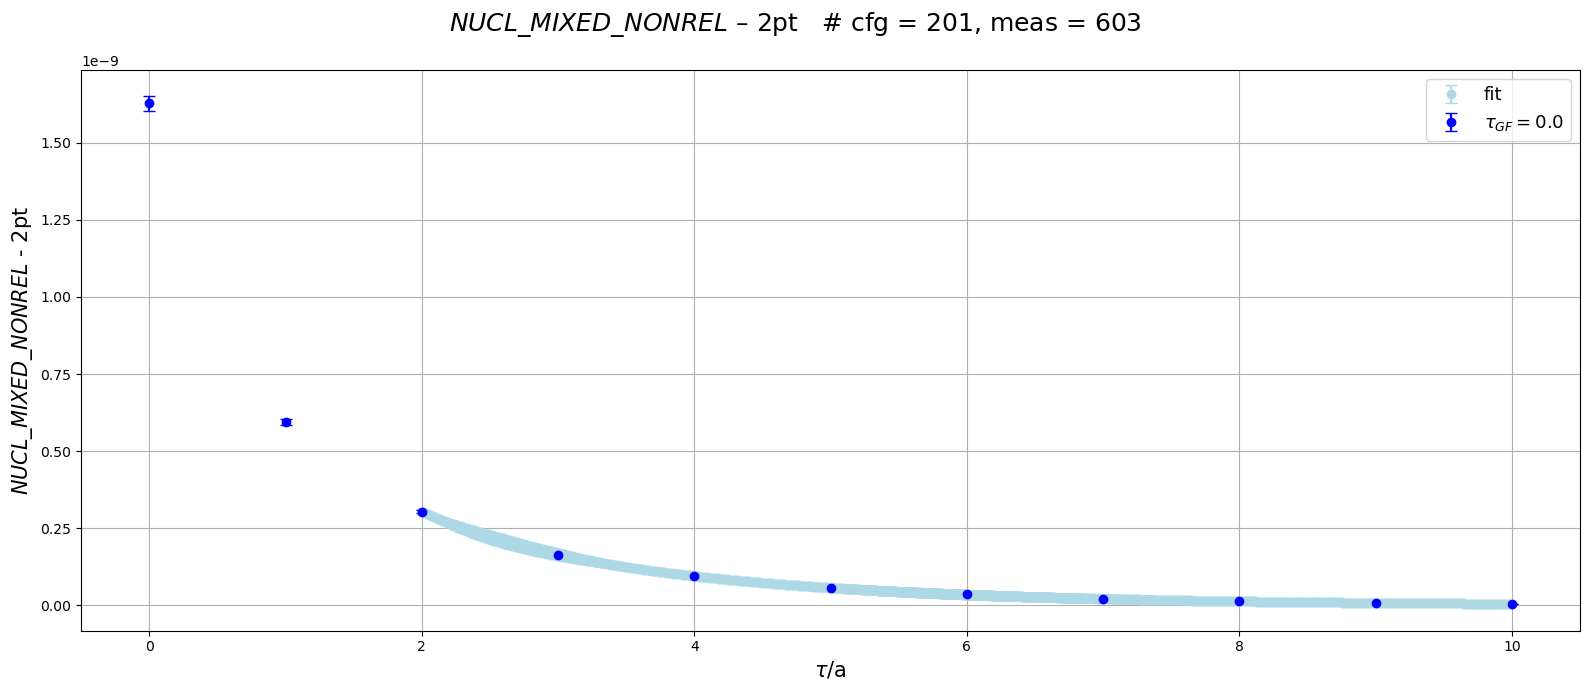

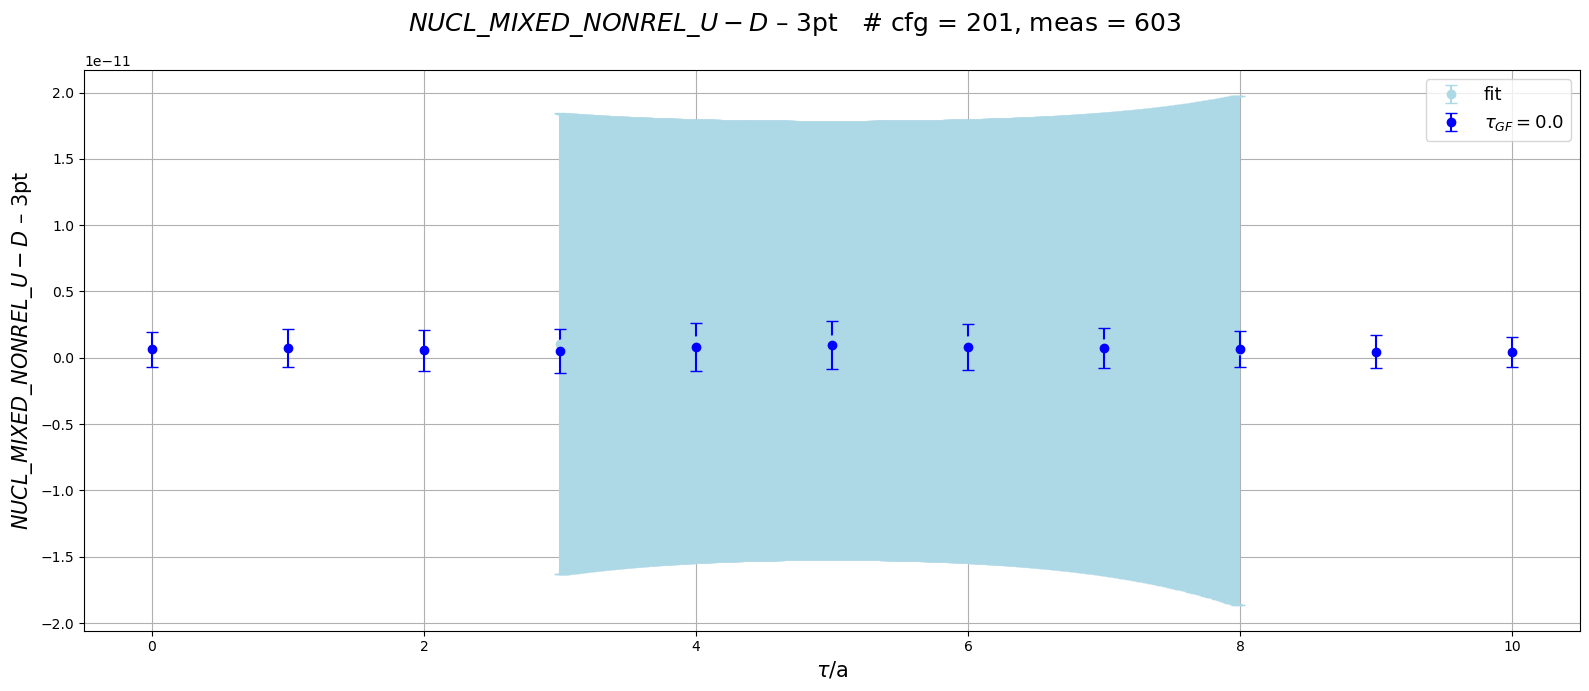

In [18]:
plot_all_flows(15, "im", cfglist, 2, 10, 3, 8)

C2 Fit from t =  2  to  9 

C3 Fit from t =  3  to  7 

Points included for fit:  13
{N2pt, N3pt}={3,2} state fit: 9 parameters

DOF =  4
Flow tau =  0.0
Akaike Information Criterion (AIC) = 18.683157725340745
Corrected AIC (AICc) = 78.68315772534075
Total Chi-Square = 0.6831577253407463
Chi-Square per DOF = 0.17078943133518656
Fit parameter:

  M0 = 0.4475(0816) = 0.44752349434 ± 0.08164483894
A0^2 = 4.43(507)e-10 = 0.00000000044 ± 0.00000000051
  M1 = 0.8778(13240) = 0.87776771920 ± 1.32401537062
A1^2 = 3.09(2656)e-10 = 0.00000000031 ± 0.00000000266
  M2 = 0.8587(0057) = 0.85872670895 ± 0.00569267279
A2^2 = 4.00(2010)e-10 = 0.00000000040 ± 0.00000000201
 O00 = 1.3336(7642) = 1.33359996711 ± 0.76424040190
 O01 = -0.1141(9336) = -0.11405298074 ± 0.93362116065
 O11 = 0.5766(42837) = 0.57661190057 ± 4.28370964156

 A1^2 / A0^2 = 1.7140(74883) = 1.713999 ± 7.488306




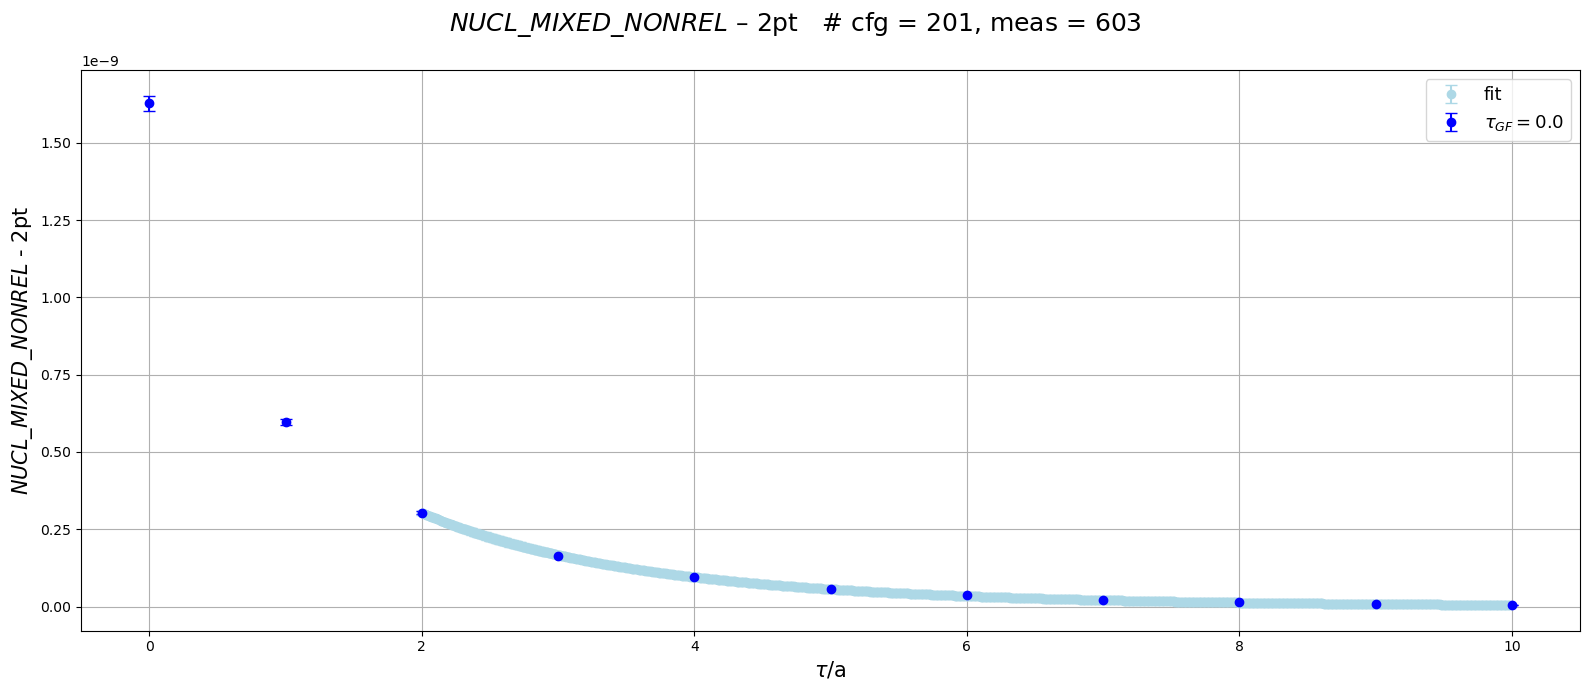

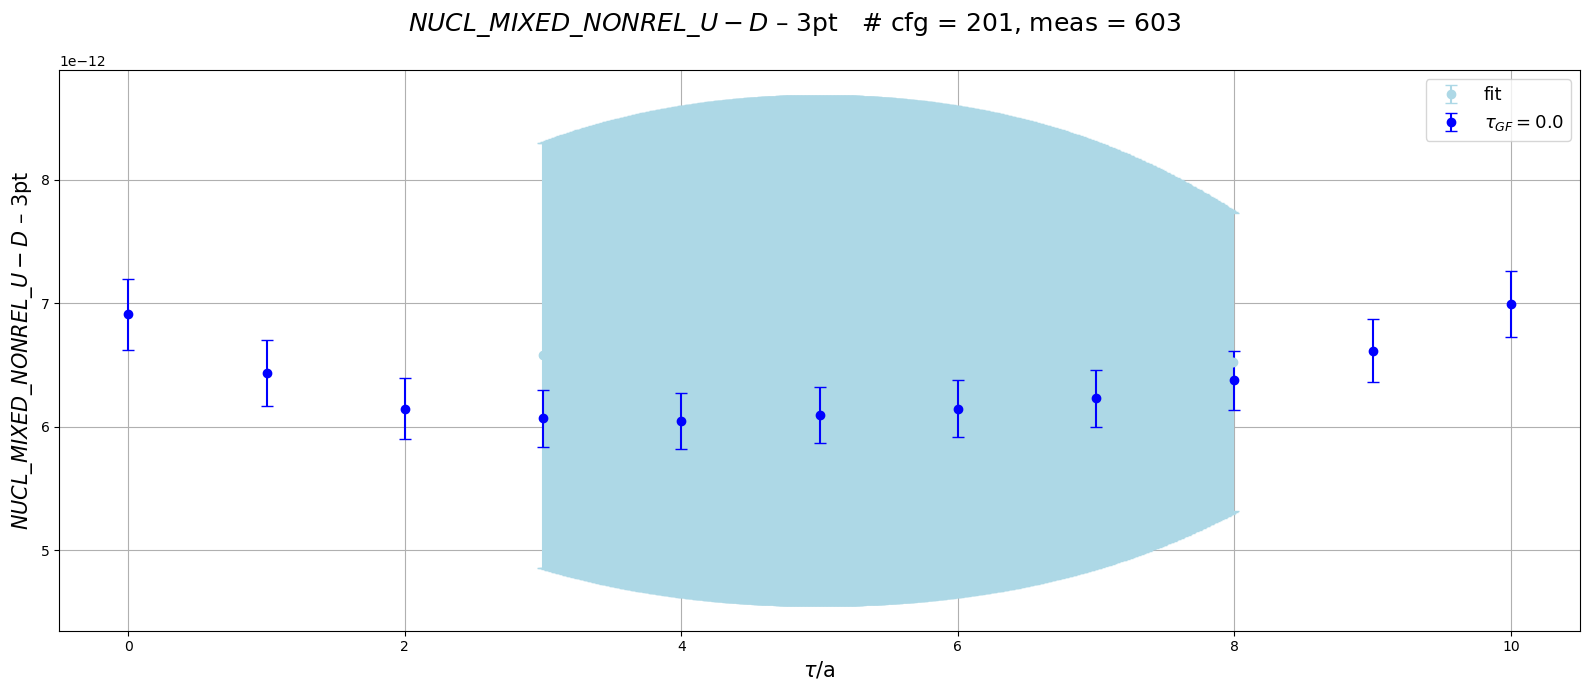

In [19]:
plot_all_flows(3, "im", cfglist, 2, 10, 3, 8)